## 1. SetUp

In [1]:
import os, json, yaml, math, gc, random, shutil, contextlib
from pathlib import Path
from PIL import Image

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm.auto import tqdm
from ultralytics import YOLO
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)
print("Device:", device, "| torch", torch.__version__)

def autocast_ctx():
    return torch.autocast(device_type="cuda", enabled=True) if device=="cuda" else contextlib.nullcontext()

Device: cuda | torch 2.7.1+cu128


## 2. Path Declaration and COCO --> YOLO Conversion

In [2]:
# ----------------------------------------------------------------------------
# 0. Paths & COCO→YOLO conversion
# ----------------------------------------------------------------------------

# Update these paths based on your local system
COCO_ROOT     = Path("D:/EWU/10th Semester/CSE475/LABS/project/DINO/Final-1")  # folder containing train/ and valid/
TRAIN_IMG_DIR = COCO_ROOT / "train"
TRAIN_ANN     = TRAIN_IMG_DIR / "_annotations.coco.json"
VAL_IMG_DIR   = COCO_ROOT / "valid"
VAL_ANN       = VAL_IMG_DIR / "_annotations.coco.json"
WORK          = Path("D:/EWU/10th Semester/CSE475/LABS/Project/DINO/SSL-DINO")  # output directory (can rename)
SSL_W         = WORK / "ssl_yolo_backbone.pt"
WORK.mkdir(parents=True, exist_ok=True)

# Create output directory structure
for split in ["train", "valid", "test"]:
    for sub in ["images", "labels"]:
        (WORK / split / sub).mkdir(parents=True, exist_ok=True)

# Function to convert COCO bbox to YOLO format
def coco2yolo(box, w, h):
    x, y, w_box, h_box = box
    return ((x + w_box/2) / w, (y + h_box/2) / h, w_box / w, h_box / h)

# Convert one split from COCO to YOLO format
def convert(split, img_dir, ann_file, out_dir):
    with open(ann_file, "r") as f:
        coco = json.load(f)

    id2img = {img["id"]: img for img in coco["images"]}
    imgs_o = out_dir / split / "images"
    labs_o = out_dir / split / "labels"

    for ann in coco["annotations"]:
        img = id2img[ann["image_id"]]
        yolo_box = coco2yolo(ann["bbox"], img["width"], img["height"])
        cls = ann["category_id"] - 1  # Class index starts from 0 in YOLO
        label_path = labs_o / f"{Path(img['file_name']).stem}.txt"
        with open(label_path, "a") as f:
            f.write(f"{cls} " + " ".join(f"{v:.6f}" for v in yolo_box) + "\n")

    for img in coco["images"]:
        shutil.copy(img_dir / img["file_name"], imgs_o / img["file_name"])

# ----------------------------------------------------------------------------
# 1. Perform Conversion
# ----------------------------------------------------------------------------
convert("train", TRAIN_IMG_DIR, TRAIN_ANN, WORK)
convert("valid", VAL_IMG_DIR,   VAL_ANN,   WORK)
convert("test",  TRAIN_IMG_DIR, TRAIN_ANN, WORK)  # Optional test reuse


## 3. Save the YAML file

In [3]:
import yaml

cats  = json.load(open(TRAIN_ANN))["categories"]
names = [c["name"] for c in sorted(cats, key=lambda x: x["id"])]
data_cfg = {
    "path":  str(WORK),
    "train": "train/images",
    "val":   "valid/images",
    "test":  "test/images",
    "nc":    len(names),
    "names": names
}
DATA = WORK / "data_Sunflower.yaml"
(DATA).write_text(yaml.dump(data_cfg))

142

## 4. Multi-crop Augmentation (DINOv2-style: 2 global + 8 local)

In [4]:

class MultiCropDINO(Dataset):
    SUPP=('*.jpg','*.jpeg','*.png','*.JPG','*.JPEG','*.PNG')
    def __init__(self, roots, g_size=224, l_size=96, n_local=8):
        self.files=[p for r in roots for s in self.SUPP for p in Path(r).rglob(s)]
        if not self.files: raise RuntimeError("No images found for SSL.")
        self.g1 = transforms.Compose([
            transforms.RandomResizedCrop(g_size, scale=(0.4, 1.0), interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(0.4,0.4,0.4,0.1),
            transforms.RandomGrayscale(0.2),
            transforms.GaussianBlur(1, 0.1),
            transforms.ToTensor()
        ])
        self.g2 = transforms.Compose([
            transforms.RandomResizedCrop(g_size, scale=(0.4, 1.0), interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(0.4,0.4,0.4,0.1),
            transforms.RandomGrayscale(0.2),
            transforms.ToTensor()
        ])
        self.local = transforms.Compose([
            transforms.RandomResizedCrop(l_size, scale=(0.05, 0.4), interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.Resize(g_size, interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(0.4,0.4,0.4,0.1),
            transforms.RandomGrayscale(0.2),
            transforms.ToTensor()
        ])
        self.n_local = n_local
    def __len__(self): return len(self.files)
    def __getitem__(self, idx):
        img = Image.open(self.files[idx]).convert("RGB")
        crops=[self.g1(img), self.g2(img)]
        crops.extend([self.local(img) for _ in range(self.n_local)])
        return crops

## 5. Build YOLO V12s model type backbone dino-v2 style

In [3]:
detector = YOLO("yolo12s.pt")   # requires Ultralytics with YOLOv10 assets
model = detector.model

student_bb = model.model[0].to(device)
teacher_bb = YOLO("yolo12s.pt").model.model[0].to(device)
teacher_bb.load_state_dict(student_bb.state_dict())
for p in teacher_bb.parameters(): p.requires_grad=False

def _pick_last_feat(out):
    """Return a tensor representing the deepest feature map/vector from backbone output."""
    if isinstance(out, (list, tuple)) and len(out) > 0:
        t = out[-1]
    elif isinstance(out, dict) and len(out) > 0:
        t = list(out.values())[-1]
    else:
        t = out
    if not torch.is_tensor(t):
        # some modules could return nested structures
        if isinstance(t, (list, tuple)) and len(t) > 0 and torch.is_tensor(t[-1]):
            t = t[-1]
        elif isinstance(t, dict) and len(t) > 0 and torch.is_tensor(list(t.values())[-1]):
            t = list(t.values())[-1]
        else:
            raise RuntimeError("Backbone output type not understood.")
    return t

class BackboneEncoder(nn.Module):
    def __init__(self, bb): super().__init__(); self.bb=bb
    def forward(self, x):
        out = self.bb(x)
        t = _pick_last_feat(out)
        # shape adapt: [B,C,H,W] → GAP; [B,C,T] → mean over T; [B,C] → as-is; else flatten
        if t.ndim == 4:
            z = t.mean(dim=(2,3))
        elif t.ndim == 3:
            z = t.mean(dim=2)
        elif t.ndim == 2:
            z = t
        else:
            z = t.view(t.size(0), -1)
        return z

student_enc = BackboneEncoder(student_bb).to(device)
teacher_enc = BackboneEncoder(teacher_bb).to(device)

with torch.no_grad():
    dmy = torch.zeros(1,3,224,224,device=device)
    feat_dim = student_enc(dmy).shape[1]
print("Backbone feature dim:", feat_dim)

Backbone feature dim: 32


## 6. DINO-v2 style projection head and loss function

In [6]:
OUT_DIM = 256

def projector(in_dim, hid=2048, out=OUT_DIM):
    return nn.Sequential(
        nn.Linear(in_dim, hid), nn.GELU(), nn.BatchNorm1d(hid),
        nn.Linear(hid, out)
    )

student_head = projector(feat_dim).to(device)
teacher_head = projector(feat_dim).to(device)
teacher_head.load_state_dict(student_head.state_dict())
for p in teacher_head.parameters(): p.requires_grad=False

class DINOLoss(nn.Module):
    def __init__(self, out_dim, n_global=2,
                 teacher_temp_warm=0.04, teacher_temp=0.07,
                 warmup_frac=0.1, total_epochs=100,
                 center_m=0.9, student_temp=0.1):
        super().__init__()
        self.n_global=n_global
        self.t_warm, self.t_final = teacher_temp_warm, teacher_temp
        self.warmup_frac, self.T = warmup_frac, total_epochs
        self.cm = center_m
        self.student_temp = student_temp
        self.register_buffer("center", torch.zeros(1,out_dim))
    def teacher_T(self, epoch):
        if epoch < self.warmup_frac*self.T:
            a=epoch/(self.warmup_frac*self.T)
            return self.t_warm + (self.t_final-self.t_warm)*a
        return self.t_final
    def forward(self, s_out, t_out, epoch):
        Tt = self.teacher_T(epoch)
        s_logits = [s/self.student_temp for s in s_out]
        t_probs  = [F.softmax((t - self.center)/Tt, dim=-1).detach() for t in t_out]
        loss=0; cnt=0
        for iq, q in enumerate(t_probs):
            for v, s in enumerate(s_logits):
                if v==iq:  # skip same-index global view
                    continue
                loss += -(q * F.log_softmax(s, dim=-1)).sum(1).mean()
                cnt += 1
        loss /= max(cnt,1)
        with torch.no_grad():
            batch_center = torch.cat(t_out, 0).mean(0, keepdim=True)
            self.center = self.center*self.cm + (1-self.cm)*batch_center
        return loss


## 7. DINOv2-style self training loop with hyperparameter and optimizer

In [8]:

EPOCHS     = 50       # increase to 50–100 for stronger transfer
BATCH      = 32
ACCUM      = 1
LR         = 5e-4
WD         = 0.05
EMA0       = 0.996
N_LOCAL    = 8
NUM_WORKERS= 0

if SSL_W.exists():
    print("✓ SSL backbone cache found – skipping DINOv2-style pretrain")
else:
    print("\n DINOv2-style pretraining on YOLOv12s backbone …")
    ds = MultiCropDINO([WORK/"train/images", WORK/"valid/images", WORK/"test/images"],
                       g_size=224, l_size=96, n_local=N_LOCAL)
    dl = DataLoader(ds, batch_size=BATCH, shuffle=True, num_workers=NUM_WORKERS,
                    pin_memory=True, drop_last=True)

    params = list(student_enc.parameters()) + list(student_head.parameters())
    opt = torch.optim.AdamW(params, lr=LR, weight_decay=WD)
    lr_sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS)
    scaler = torch.amp.GradScaler(enabled=(device=="cuda"))
    loss_fn = DINOLoss(OUT_DIM, n_global=2,
                       teacher_temp_warm=0.04, teacher_temp=0.07,
                       warmup_frac=0.1, total_epochs=EPOCHS,
                       center_m=0.9, student_temp=0.1).to(device)

    steps_per_epoch = len(dl)
    total_steps = steps_per_epoch * EPOCHS
    gstep = 0

    student_enc.train(); student_head.train()
    for ep in range(EPOCHS):
        ep_loss=0.0; accum=0
        opt.zero_grad(set_to_none=True)
        for views in tqdm(dl, desc=f"SSL Ep {ep+1}/{EPOCHS}", leave=False):
            views = [v.to(device) for v in views]  # [g1, g2, l1..lN]
            with autocast_ctx():
                s_feats = [student_enc(v) for v in views]
                s_outs  = [student_head(z) for z in s_feats]              # all crops
                with torch.no_grad():
                    t_feats = [teacher_enc(v) for v in views[:2]]         # globals only
                    t_outs  = [teacher_head(z) for z in t_feats]
                loss = loss_fn(s_outs, t_outs, epoch=ep) / ACCUM

            scaler.scale(loss).backward()
            accum += 1
            if accum == ACCUM:
                scaler.unscale_(opt)
                nn.utils.clip_grad_norm_(params, 3.0)
                scaler.step(opt); scaler.update()
                opt.zero_grad(set_to_none=True)
                accum = 0

                # EMA update (cosine momentum) for teacher backbone + head
                m = 1 - (1-EMA0) * (math.cos(math.pi*gstep/total_steps)+1)/2
                with torch.no_grad():
                    for ps, pt in zip(student_bb.parameters(), teacher_bb.parameters()):
                        pt.data.mul_(m).add_(ps.data, alpha=1-m)
                    for ps, pt in zip(student_head.parameters(), teacher_head.parameters()):
                        pt.data.mul_(m).add_(ps.data, alpha=1-m)
                gstep += 1

            ep_loss += loss.item() * ACCUM

        lr_sched.step()
        print(f"SSL Epoch {ep+1:02d}: loss={ep_loss/steps_per_epoch:.4f}")

    SSL_W.parent.mkdir(parents=True, exist_ok=True)
    torch.save(student_bb.state_dict(), SSL_W)
    del ds, dl
    gc.collect()
    print("✓ Saved SSL YOLOv12s backbone →", SSL_W)
    print("✓ DINOv2-style pretraining complete.\n")


 DINOv2-style pretraining on YOLOv12s backbone …


SSL Ep 1/50:   0%|          | 0/504 [00:00<?, ?it/s]

SSL Epoch 01: loss=5.4770


SSL Ep 2/50:   0%|          | 0/504 [00:00<?, ?it/s]

SSL Epoch 02: loss=5.2078


SSL Ep 3/50:   0%|          | 0/504 [00:00<?, ?it/s]

SSL Epoch 03: loss=4.7260


SSL Ep 4/50:   0%|          | 0/504 [00:00<?, ?it/s]

SSL Epoch 04: loss=4.5852


SSL Ep 5/50:   0%|          | 0/504 [00:00<?, ?it/s]

SSL Epoch 05: loss=4.5332


SSL Ep 6/50:   0%|          | 0/504 [00:00<?, ?it/s]

SSL Epoch 06: loss=4.5236


SSL Ep 7/50:   0%|          | 0/504 [00:00<?, ?it/s]

SSL Epoch 07: loss=4.5226


SSL Ep 8/50:   0%|          | 0/504 [00:00<?, ?it/s]

SSL Epoch 08: loss=4.4809


SSL Ep 9/50:   0%|          | 0/504 [00:00<?, ?it/s]

SSL Epoch 09: loss=4.5134


SSL Ep 10/50:   0%|          | 0/504 [00:00<?, ?it/s]

SSL Epoch 10: loss=4.5362


SSL Ep 11/50:   0%|          | 0/504 [00:00<?, ?it/s]

SSL Epoch 11: loss=4.5538


SSL Ep 12/50:   0%|          | 0/504 [00:00<?, ?it/s]

SSL Epoch 12: loss=4.5611


SSL Ep 13/50:   0%|          | 0/504 [00:00<?, ?it/s]

SSL Epoch 13: loss=4.6216


SSL Ep 14/50:   0%|          | 0/504 [00:00<?, ?it/s]

SSL Epoch 14: loss=4.6337


SSL Ep 15/50:   0%|          | 0/504 [00:00<?, ?it/s]

SSL Epoch 15: loss=4.6726


SSL Ep 16/50:   0%|          | 0/504 [00:00<?, ?it/s]

SSL Epoch 16: loss=4.7064


SSL Ep 17/50:   0%|          | 0/504 [00:00<?, ?it/s]

SSL Epoch 17: loss=4.7500


SSL Ep 18/50:   0%|          | 0/504 [00:00<?, ?it/s]

SSL Epoch 18: loss=4.7713


SSL Ep 19/50:   0%|          | 0/504 [00:00<?, ?it/s]

SSL Epoch 19: loss=4.7893


SSL Ep 20/50:   0%|          | 0/504 [00:00<?, ?it/s]

SSL Epoch 20: loss=4.8169


SSL Ep 21/50:   0%|          | 0/504 [00:00<?, ?it/s]

SSL Epoch 21: loss=4.8361


SSL Ep 22/50:   0%|          | 0/504 [00:00<?, ?it/s]

SSL Epoch 22: loss=4.8657


SSL Ep 23/50:   0%|          | 0/504 [00:00<?, ?it/s]

SSL Epoch 23: loss=4.8888


SSL Ep 24/50:   0%|          | 0/504 [00:00<?, ?it/s]

SSL Epoch 24: loss=4.9150


SSL Ep 25/50:   0%|          | 0/504 [00:00<?, ?it/s]

SSL Epoch 25: loss=4.9391


SSL Ep 26/50:   0%|          | 0/504 [00:00<?, ?it/s]

SSL Epoch 26: loss=4.9585


SSL Ep 27/50:   0%|          | 0/504 [00:00<?, ?it/s]

SSL Epoch 27: loss=4.9740


SSL Ep 28/50:   0%|          | 0/504 [00:00<?, ?it/s]

SSL Epoch 28: loss=4.9784


SSL Ep 29/50:   0%|          | 0/504 [00:00<?, ?it/s]

SSL Epoch 29: loss=4.9941


SSL Ep 30/50:   0%|          | 0/504 [00:00<?, ?it/s]

SSL Epoch 30: loss=4.9964


SSL Ep 31/50:   0%|          | 0/504 [00:00<?, ?it/s]

SSL Epoch 31: loss=5.0037


SSL Ep 32/50:   0%|          | 0/504 [00:00<?, ?it/s]

SSL Epoch 32: loss=5.0112


SSL Ep 33/50:   0%|          | 0/504 [00:00<?, ?it/s]

SSL Epoch 33: loss=5.0202


SSL Ep 34/50:   0%|          | 0/504 [00:00<?, ?it/s]

SSL Epoch 34: loss=5.0301


SSL Ep 35/50:   0%|          | 0/504 [00:00<?, ?it/s]

SSL Epoch 35: loss=5.0249


SSL Ep 36/50:   0%|          | 0/504 [00:00<?, ?it/s]

SSL Epoch 36: loss=5.0315


SSL Ep 37/50:   0%|          | 0/504 [00:00<?, ?it/s]

SSL Epoch 37: loss=5.0329


SSL Ep 38/50:   0%|          | 0/504 [00:00<?, ?it/s]

SSL Epoch 38: loss=5.0354


SSL Ep 39/50:   0%|          | 0/504 [00:00<?, ?it/s]

SSL Epoch 39: loss=5.0412


SSL Ep 40/50:   0%|          | 0/504 [00:00<?, ?it/s]

SSL Epoch 40: loss=5.0406


SSL Ep 41/50:   0%|          | 0/504 [00:00<?, ?it/s]

SSL Epoch 41: loss=5.0435


SSL Ep 42/50:   0%|          | 0/504 [00:00<?, ?it/s]

SSL Epoch 42: loss=5.0440


SSL Ep 43/50:   0%|          | 0/504 [00:00<?, ?it/s]

SSL Epoch 43: loss=5.0449


SSL Ep 44/50:   0%|          | 0/504 [00:00<?, ?it/s]

SSL Epoch 44: loss=5.0479


SSL Ep 45/50:   0%|          | 0/504 [00:00<?, ?it/s]

SSL Epoch 45: loss=5.0471


SSL Ep 46/50:   0%|          | 0/504 [00:00<?, ?it/s]

SSL Epoch 46: loss=5.0449


SSL Ep 47/50:   0%|          | 0/504 [00:00<?, ?it/s]

SSL Epoch 47: loss=5.0409


SSL Ep 48/50:   0%|          | 0/504 [00:00<?, ?it/s]

SSL Epoch 48: loss=5.0439


SSL Ep 49/50:   0%|          | 0/504 [00:00<?, ?it/s]

SSL Epoch 49: loss=5.0478


SSL Ep 50/50:   0%|          | 0/504 [00:00<?, ?it/s]

SSL Epoch 50: loss=5.0441
✓ Saved SSL YOLOv12s backbone → D:\EWU\10th Semester\CSE475\LABS\Project\DINO\SSL-DINO\ssl_yolo_backbone.pt
✓ DINOv2-style pretraining complete.



## 8. PCA Visualization of K-Means clustering

PCA Feature matrix: (1000, 32)


d:\EWU\10th Semester\CSE475\LABS\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


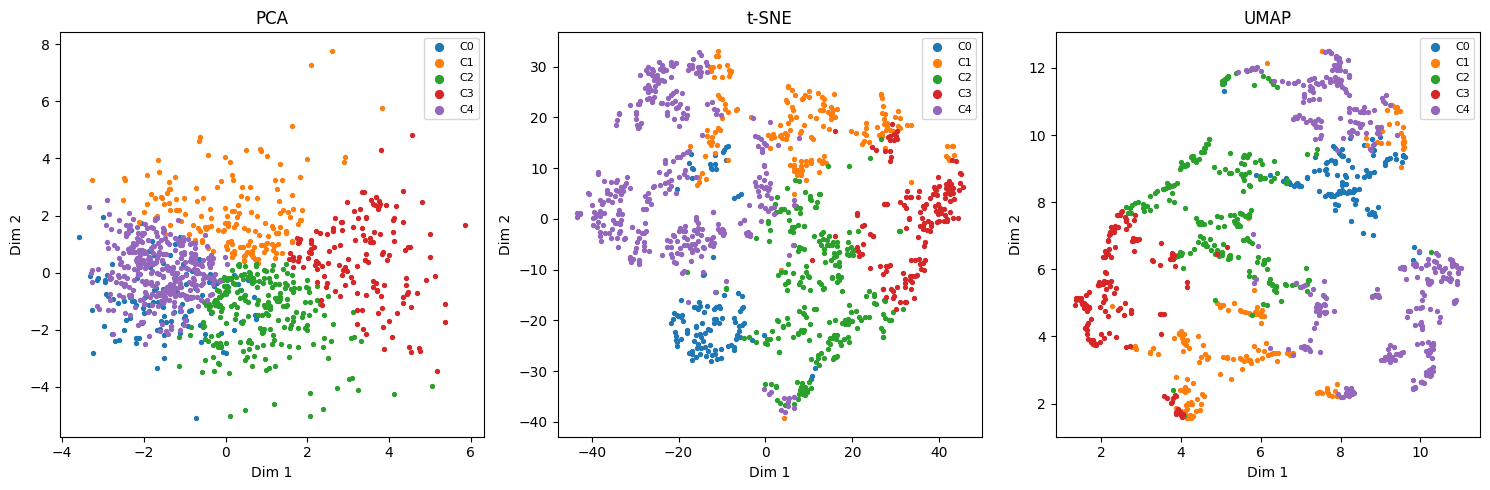

In [4]:
import umap.umap_ as umap
from sklearn.manifold import TSNE

WORK          = Path("D:/EWU/10th Semester/CSE475/LABS/Project/DINO/SSL-DINO")

SSL_W = WORK / "ssl_yolo_backbone.pt"
DATA = WORK / "data_Sunflower.yaml"
det_pca = YOLO("yolo12s.pt")
det_pca.model.model[0].load_state_dict(torch.load(SSL_W, map_location="cpu"), strict=False)
bb = det_pca.model.model[0].to(device).eval()

class BBEnc(nn.Module):
    def __init__(self, bb): super().__init__(); self.bb=bb
    def forward(self, x):
        out = self.bb(x)
        t = _pick_last_feat(out)
        if t.ndim == 4:
            z = t.mean(dim=(2,3))
        elif t.ndim == 3:
            z = t.mean(dim=2)
        elif t.ndim == 2:
            z = t
        else:
            z = t.view(t.size(0), -1)
        return z

enc_pca = BBEnc(bb).to(device)
tfm_pca = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])

# sample images for PCA
IMG_DIRS = [WORK/"train/images", WORK/"valid/images"]
files=[]
for d in IMG_DIRS:
    if d.exists(): files += list(d.glob("*.*"))
random.shuffle(files)
files = files[:1000] if len(files)>1000 else files

feats=[]
with torch.no_grad():
    for p in files:
        try:
            img = Image.open(p).convert("RGB")
        except:
            continue
        x = tfm_pca(img).unsqueeze(0).to(device)
        z = enc_pca(x)
        feats.append(z.squeeze(0).cpu().numpy())
feats = np.stack(feats, axis=0)
print("PCA Feature matrix:", feats.shape)

pca = PCA(n_components=2, random_state=42)
xy_pca = pca.fit_transform(feats)

# t-SNE
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
xy_tsne = tsne.fit_transform(feats)

# UMAP
umap_model = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
xy_umap = umap_model.fit_transform(feats)

# ================================
# Clustering (Same labels for all plots)
# ================================
k = 5
lab = KMeans(n_clusters=k, n_init=10, random_state=42).fit_predict(feats)

# ================================
# Plotting
# ================================
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
methods = [("PCA", xy_pca), ("t-SNE", xy_tsne), ("UMAP", xy_umap)]

for ax, (title, xy) in zip(axes, methods):
    for i in range(k):
        m = (lab == i)
        ax.scatter(xy[m, 0], xy[m, 1], s=8, label=f"C{i}")
    ax.set_title(title)
    ax.set_xlabel("Dim 1")
    ax.set_ylabel("Dim 2")
    ax.legend(markerscale=2, fontsize=8)

plt.tight_layout()
plt.show()


## 9. Detector Fine-Tuning with SSL Backbone

In [2]:
WORK          = Path("D:/EWU/10th Semester/CSE475/LABS/Project/DINO/SSL-DINO")

det = YOLO("D:/EWU/10th Semester/CSE475/LABS/ASSIGNMENT/Converted_Dataset/yolov12_train/weights/best.pt")
SSL_W = WORK / "ssl_yolo_backbone.pt"
missing, unexpected = det.model.model[0].load_state_dict(torch.load(SSL_W, map_location="cpu"), strict=False)
print("Loaded backbone with missing:", len(missing), " unexpected:", len(unexpected))
DATA = WORK / "data_Sunflower.yaml"
det.train(data=str(DATA),
          epochs=50,
          imgsz=640,
          batch=8,
          save=True,
          save_period=1,
          project=str(WORK),
          name="ssl_yolov12s_dinov2",
          device=0 if device=="cuda" else "cpu")

Loaded backbone with missing: 0  unexpected: 0
New https://pypi.org/project/ultralytics/8.3.179 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.177  Python-3.13.3 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce RTX 5060 Ti, 16311MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=D:\EWU\10th Semester\CSE475\LABS\Project\DINO\SSL-DINO\data_Sunflower.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=D:/EWU/10th

train: Scanning D:\EWU\10th Semester\CSE475\LABS\Project\DINO\SSL-DINO\train\labels.cache... 3957 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3957/3957 [00:00<?, ?it/s]

train: D:\EWU\10th Semester\CSE475\LABS\Project\DINO\SSL-DINO\train\images\20240116_122814-mp4_frame11_jpg.rf.650cefb9416fc89e311a7aff32bdf073.jpg: 552 duplicate labels removed
train: D:\EWU\10th Semester\CSE475\LABS\Project\DINO\SSL-DINO\train\images\20240116_122814-mp4_frame11_jpg.rf.89dbffb6bc606c0c43f3f6083ba9dd86.jpg: 552 duplicate labels removed
train: D:\EWU\10th Semester\CSE475\LABS\Project\DINO\SSL-DINO\train\images\20240116_122814-mp4_frame11_jpg.rf.d6a25166d65471f3fc9120c5a5b6c65e.jpg: 552 duplicate labels removed
train: D:\EWU\10th Semester\CSE475\LABS\Project\DINO\SSL-DINO\train\images\20240116_122814-mp4_frame12_jpg.rf.479de2762ee15cc258b3199caa859f97.jpg: 232 duplicate labels removed
train: D:\EWU\10th Semester\CSE475\LABS\Project\DINO\SSL-DINO\train\images\20240116_122814-mp4_frame12_jpg.rf.a4e50cab7373e2e08190eef56d20b49f.jpg: 232 duplicate labels removed
train: D:\EWU\10th Semester\CSE475\LABS\Project\DINO\SSL-DINO\train\images\20240116_122814-mp4_frame12_jpg.rf.bc2b7

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access  (ping: 0.30.1 ms, read: 4.91.0 MB/s, size: 96.9 KB)


val: Scanning D:\EWU\10th Semester\CSE475\LABS\Project\DINO\SSL-DINO\valid\labels.cache... 165 images, 0 backgrounds, 0 corrupt: 100%|██████████| 165/165 [00:00<?, ?it/s]

val: D:\EWU\10th Semester\CSE475\LABS\Project\DINO\SSL-DINO\valid\images\20240116_122814-mp4_frame20_jpg.rf.00b714a13e284a26f6e9f14acb8a48bd.jpg: 400 duplicate labels removed
val: D:\EWU\10th Semester\CSE475\LABS\Project\DINO\SSL-DINO\valid\images\20240116_122814-mp4_frame22_jpg.rf.4c77c9f0d80049bf7f81a774ca46b37a.jpg: 342 duplicate labels removed
val: D:\EWU\10th Semester\CSE475\LABS\Project\DINO\SSL-DINO\valid\images\20240116_122814-mp4_frame24_jpg.rf.9b7305a96010f47cfa1de2b6740b1bbb.jpg: 360 duplicate labels removed
val: D:\EWU\10th Semester\CSE475\LABS\Project\DINO\SSL-DINO\valid\images\20240116_122814-mp4_frame25_jpg.rf.c81a8c525aa33e1691370763fa8c20cd.jpg: 160 duplicate labels removed
val: D:\EWU\10th Semester\CSE475\LABS\Project\DINO\SSL-DINO\valid\images\20240116_122814-mp4_frame32_jpg.rf.ed0515a80966b09102e94d66ee55a52d.jpg: 186 duplicate labels removed
val: D:\EWU\10th Semester\CSE475\LABS\Project\DINO\SSL-DINO\valid\images\20240116_122814-mp4_frame36_jpg.rf.3054a866ee403147e

Plotting labels to D:\EWU\10th Semester\CSE475\LABS\Project\DINO\SSL-DINO\ssl_yolov12s_dinov2\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.0005), 119 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to D:\EWU\10th Semester\CSE475\LABS\Project\DINO\SSL-DINO\ssl_yolov12s_dinov2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      6.11G      1.218     0.6294     0.9618        195        640: 100%|██████████| 495/495 [01:35<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.49it/s]


                   all        165      13823       0.86      0.832      0.911      0.575

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      6.65G      1.253     0.6292      0.964       1071        640: 100%|██████████| 495/495 [01:24<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.19it/s]

                   all        165      13823      0.853      0.828      0.906      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      6.65G      1.266     0.6387     0.9682        667        640: 100%|██████████| 495/495 [01:35<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.05it/s]

                   all        165      13823      0.859      0.828      0.907      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      6.65G      1.266     0.6367     0.9694        404        640: 100%|██████████| 495/495 [01:37<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.27it/s]

                   all        165      13823      0.854      0.834      0.907      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      6.65G      1.267     0.6331     0.9699        434        640: 100%|██████████| 495/495 [01:37<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.59it/s]

                   all        165      13823      0.859      0.831      0.908      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      6.65G      1.263     0.6365      0.969        433        640: 100%|██████████| 495/495 [01:41<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.97it/s]

                   all        165      13823      0.846      0.835      0.905      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      6.65G      1.261     0.6318     0.9667        605        640: 100%|██████████| 495/495 [01:22<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.37it/s]

                   all        165      13823      0.854      0.828      0.906      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      6.65G      1.253     0.6246     0.9666        752        640: 100%|██████████| 495/495 [01:21<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.33it/s]

                   all        165      13823      0.844      0.833      0.904      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      6.65G      1.254     0.6267      0.966        310        640: 100%|██████████| 495/495 [01:28<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.55it/s]

                   all        165      13823      0.849      0.843       0.91      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      6.65G      1.252     0.6249     0.9637        707        640: 100%|██████████| 495/495 [01:37<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.02it/s]

                   all        165      13823      0.848      0.839      0.909      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      6.65G      1.247     0.6205     0.9593        381        640: 100%|██████████| 495/495 [01:33<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.89it/s]

                   all        165      13823      0.853      0.835      0.908      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      6.65G      1.247     0.6207     0.9631        343        640: 100%|██████████| 495/495 [01:27<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.91it/s]

                   all        165      13823      0.844      0.841      0.909      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      6.69G      1.241     0.6191     0.9608        501        640: 100%|██████████| 495/495 [01:29<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.99it/s]

                   all        165      13823      0.849      0.844      0.912      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      6.69G      1.235     0.6148     0.9581        957        640: 100%|██████████| 495/495 [01:27<00:00,  5.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.08it/s]

                   all        165      13823      0.854      0.836       0.91      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      6.69G      1.241     0.6169     0.9597        671        640: 100%|██████████| 495/495 [01:26<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.07it/s]

                   all        165      13823      0.859      0.834       0.91      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      6.73G      1.225      0.606     0.9582        447        640: 100%|██████████| 495/495 [01:28<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.03it/s]

                   all        165      13823      0.855      0.842      0.913      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      6.77G      1.227     0.6062      0.957        471        640: 100%|██████████| 495/495 [01:27<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.96it/s]

                   all        165      13823      0.847      0.837      0.908      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      7.32G       1.22     0.6035     0.9537        478        640: 100%|██████████| 495/495 [01:27<00:00,  5.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.06it/s]

                   all        165      13823      0.856      0.844      0.913      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      7.32G      1.224     0.6032     0.9533        228        640: 100%|██████████| 495/495 [01:26<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.69it/s]

                   all        165      13823      0.858      0.837      0.913       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      7.92G      1.211     0.5988     0.9516        647        640: 100%|██████████| 495/495 [01:27<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.83it/s]

                   all        165      13823      0.859      0.834       0.91      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      7.92G      1.215     0.5976     0.9518        557        640: 100%|██████████| 495/495 [01:28<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.11it/s]

                   all        165      13823      0.866      0.834      0.914      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      7.92G      1.205     0.5931     0.9505        786        640: 100%|██████████| 495/495 [01:26<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.09it/s]

                   all        165      13823      0.855      0.839      0.909      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      7.92G      1.199     0.5915      0.949        534        640: 100%|██████████| 495/495 [01:27<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.96it/s]

                   all        165      13823      0.856      0.837      0.909      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      7.92G      1.198      0.587     0.9488        532        640: 100%|██████████| 495/495 [01:27<00:00,  5.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.02it/s]

                   all        165      13823      0.854      0.839      0.911      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      7.92G      1.194     0.5843     0.9457        518        640: 100%|██████████| 495/495 [01:26<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.09it/s]

                   all        165      13823      0.857      0.835      0.911      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      7.92G       1.19     0.5816     0.9466        461        640: 100%|██████████| 495/495 [01:25<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.41it/s]

                   all        165      13823      0.853      0.838      0.909      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      7.92G      1.192     0.5831     0.9451       1080        640: 100%|██████████| 495/495 [01:21<00:00,  6.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.16it/s]

                   all        165      13823      0.859      0.841      0.915      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      7.92G      1.193     0.5837     0.9477        765        640: 100%|██████████| 495/495 [01:21<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.28it/s]

                   all        165      13823      0.859      0.846      0.916      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      7.92G      1.186     0.5796     0.9442        443        640: 100%|██████████| 495/495 [01:20<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.39it/s]

                   all        165      13823      0.861      0.838      0.914      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      7.92G      1.189       0.58     0.9451        406        640: 100%|██████████| 495/495 [01:20<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.37it/s]

                   all        165      13823      0.864      0.837      0.915      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      7.92G      1.176     0.5748     0.9421        841        640: 100%|██████████| 495/495 [01:21<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.35it/s]

                   all        165      13823      0.849      0.849      0.913      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      7.92G      1.173     0.5704     0.9401        428        640: 100%|██████████| 495/495 [01:20<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.26it/s]

                   all        165      13823      0.861      0.843      0.916      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      7.92G      1.169     0.5678     0.9404        556        640: 100%|██████████| 495/495 [01:20<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.29it/s]

                   all        165      13823      0.857      0.839      0.913      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      7.92G      1.167     0.5667     0.9391        362        640: 100%|██████████| 495/495 [01:20<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.40it/s]

                   all        165      13823      0.858      0.839      0.912      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      7.92G      1.161     0.5642     0.9367        665        640: 100%|██████████| 495/495 [01:21<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.36it/s]

                   all        165      13823      0.863       0.84      0.916      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      7.92G      1.151     0.5583     0.9353        456        640: 100%|██████████| 495/495 [01:20<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.29it/s]

                   all        165      13823      0.861      0.839      0.913      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      7.92G      1.155     0.5584      0.935        366        640: 100%|██████████| 495/495 [01:21<00:00,  6.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.40it/s]

                   all        165      13823      0.859      0.844      0.915      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      7.92G       1.15     0.5552     0.9323        515        640: 100%|██████████| 495/495 [01:21<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.29it/s]

                   all        165      13823      0.848      0.852      0.914      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      7.92G       1.15     0.5552      0.933        627        640: 100%|██████████| 495/495 [01:20<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.37it/s]

                   all        165      13823      0.864      0.839      0.915      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      7.92G      1.137     0.5488     0.9316        513        640: 100%|██████████| 495/495 [01:20<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.35it/s]

                   all        165      13823      0.867      0.841      0.916      0.592


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      7.92G      1.147     0.5418     0.9432        293        640: 100%|██████████| 495/495 [01:18<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.14it/s]

                   all        165      13823      0.856      0.842      0.913      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      7.92G      1.138     0.5384     0.9368        258        640: 100%|██████████| 495/495 [01:20<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.31it/s]

                   all        165      13823       0.86      0.843      0.916      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      7.92G       1.13     0.5331     0.9343        392        640: 100%|██████████| 495/495 [01:16<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.41it/s]

                   all        165      13823       0.86      0.843      0.915      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      7.92G      1.124     0.5299      0.932        447        640: 100%|██████████| 495/495 [01:16<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.41it/s]

                   all        165      13823      0.866      0.836      0.915      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      7.92G      1.119     0.5273     0.9329        443        640: 100%|██████████| 495/495 [01:17<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.40it/s]

                   all        165      13823      0.865       0.84      0.916      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      7.92G      1.112     0.5231     0.9294        335        640: 100%|██████████| 495/495 [01:16<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.32it/s]

                   all        165      13823      0.866      0.843      0.917      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      7.92G      1.108     0.5203     0.9285        368        640: 100%|██████████| 495/495 [01:17<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.40it/s]

                   all        165      13823      0.859      0.847      0.917        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      7.92G      1.098      0.515     0.9232        389        640: 100%|██████████| 495/495 [01:16<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.34it/s]

                   all        165      13823       0.86      0.845      0.917      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      7.92G      1.097     0.5131     0.9222        415        640: 100%|██████████| 495/495 [01:17<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.27it/s]

                   all        165      13823      0.857      0.846      0.915      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      7.92G      1.098     0.5124     0.9263        174        640: 100%|██████████| 495/495 [01:17<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.43it/s]

                   all        165      13823      0.862      0.846      0.916      0.598



50 epochs completed in 1.218 hours.
Optimizer stripped from D:\EWU\10th Semester\CSE475\LABS\Project\DINO\SSL-DINO\ssl_yolov12s_dinov2\weights\last.pt, 18.9MB
Optimizer stripped from D:\EWU\10th Semester\CSE475\LABS\Project\DINO\SSL-DINO\ssl_yolov12s_dinov2\weights\best.pt, 18.9MB

Validating D:\EWU\10th Semester\CSE475\LABS\Project\DINO\SSL-DINO\ssl_yolov12s_dinov2\weights\best.pt...
Ultralytics 8.3.177  Python-3.13.3 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce RTX 5060 Ti, 16311MiB)
YOLOv12s summary (fused): 159 layers, 9,231,267 parameters, 0 gradients, 21.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


                   all        165      13823      0.859      0.848      0.917      0.599
Speed: 0.3ms preprocess, 7.5ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to D:\EWU\10th Semester\CSE475\LABS\Project\DINO\SSL-DINO\ssl_yolov12s_dinov2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000019EBDF8B1C0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

## 10. Loss Curve Visualization

Available columns: ['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']


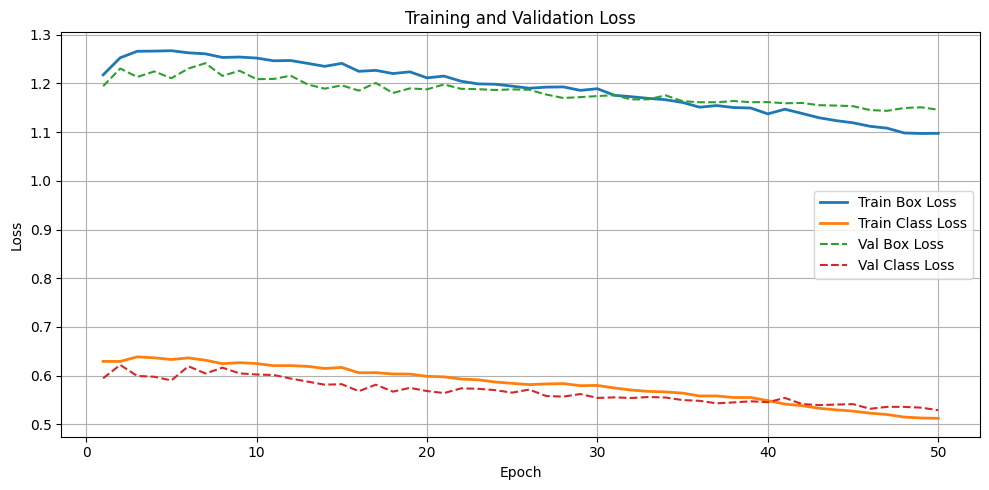

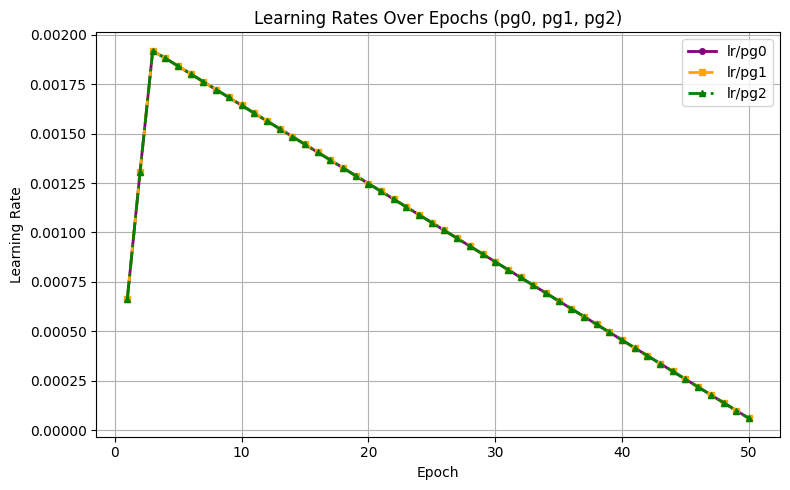

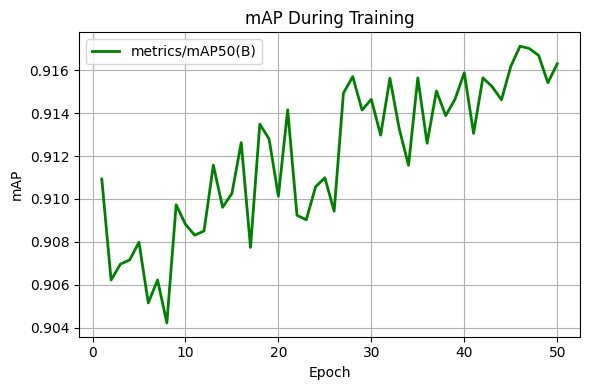

In [11]:
# ----------------------------------------------------------------------------
# 3. Visualize Training Metrics
# ----------------------------------------------------------------------------
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# Path to results.csv
results_path = Path("D:/EWU/10th Semester/CSE475/LABS/Project/DINO/SSL-DINO/ssl_yolov12s_dinov2/results.csv")

# Load CSV
df = pd.read_csv(results_path)

# Show available columns
print("Available columns:", df.columns.tolist())

# Plot Loss Curves
plt.figure(figsize=(10, 5))
plt.plot(df["epoch"], df["train/box_loss"], label="Train Box Loss", linewidth=2)
plt.plot(df["epoch"], df["train/cls_loss"], label="Train Class Loss", linewidth=2)
plt.plot(df["epoch"], df["val/box_loss"], label="Val Box Loss", linestyle="--")
plt.plot(df["epoch"], df["val/cls_loss"], label="Val Class Loss", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

lr_columns = [col for col in df.columns if col.startswith("lr/pg")]
colors = ['purple', 'orange', 'green']
styles = ['-', '--', '-.']
markers = ['o', 's', '^']

if lr_columns:
    plt.figure(figsize=(8, 5))
    for idx, col in enumerate(lr_columns):
        plt.plot(
            df["epoch"], df[col],
            label=col,
            color=colors[idx % len(colors)],
            linestyle=styles[idx % len(styles)],
            marker=markers[idx % len(markers)],
            markersize=4,
            linewidth=2
        )
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")
    plt.title("Learning Rates Over Epochs (pg0, pg1, pg2)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("No learning rate columns found.")


# Plot mAP Curve (0.5 IoU)
map_keys = ["metrics/mAP50(B)", "metrics/mAP50-95(B)"]  # version dependent
map_column = next((key for key in map_keys if key in df.columns), None)

if map_column:
    plt.figure(figsize=(6, 4))
    plt.plot(df["epoch"], df[map_column], label=map_column, color="green", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("mAP")
    plt.title("mAP During Training")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("mAP column not found. Skipping mAP plot.")


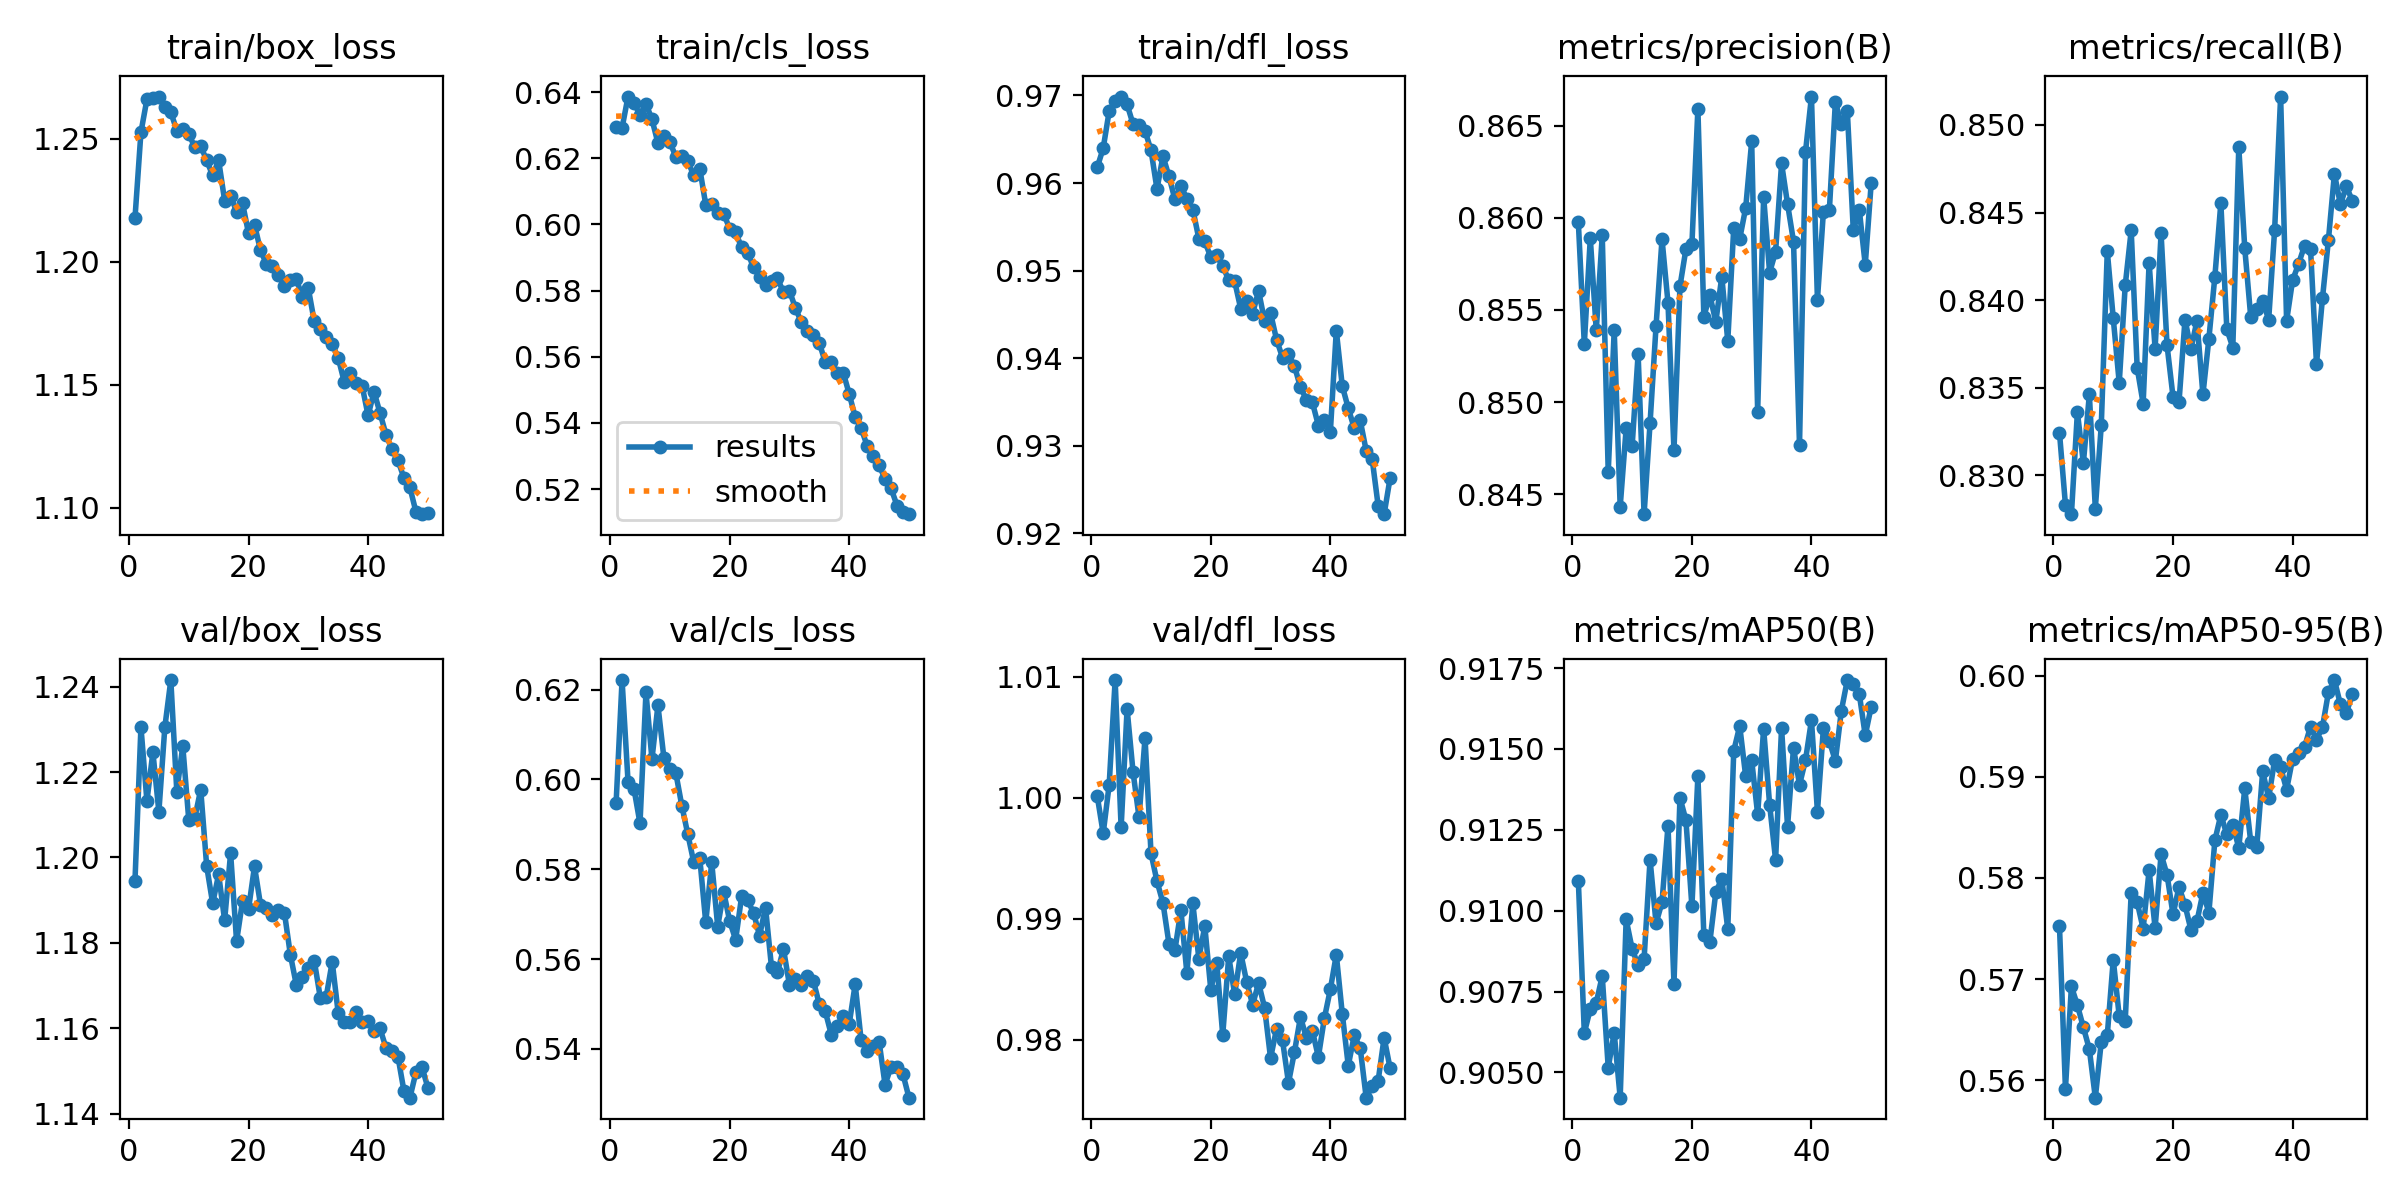

In [4]:
from PIL import Image
from IPython.display import display

results_img = WORK / "ssl_yolov12s_dinov2" / "results.png"
img = Image.open(results_img)
display(img)


## 11. Evalution

In [13]:
best_pt = Path("D:/EWU/10th Semester/CSE475/LABS/Project/DINO/SSL-DINO/ssl_yolov12s_dinov2/weights/best.pt")
 
model_det = YOLO(str(best_pt))

results = model_det.val(data=str(DATA),
                        imgsz=640,
                        batch=4,
                        device=0 if device=="cuda" else "cpu")

try:
    mp, mr, map50, map5095 = results.mean_results()
except Exception:
    mp, mr = float(results.box.mp), float(results.box.mr)
    map50, map5095 = float(results.box.map50), float(results.box.map)

print("\nValidation metrics")
print(f" Precision (mP) : {mp:.4f}")
print(f" Recall    (mR) : {mr:.4f}")
print(f" mAP@0.50      : {map50:.4f}")
print(f" mAP@0.50-0.95 : {map5095:.4f}")



Ultralytics 8.3.177  Python-3.13.3 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce RTX 5060 Ti, 16311MiB)
YOLOv12s summary (fused): 159 layers, 9,231,267 parameters, 0 gradients, 21.2 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 691.3472.3 MB/s, size: 96.8 KB)


val: Scanning D:\EWU\10th Semester\CSE475\LABS\Project\DINO\SSL-DINO\valid\labels.cache... 165 images, 0 backgrounds, 0 corrupt: 100%|██████████| 165/165 [00:00<?, ?it/s]

val: D:\EWU\10th Semester\CSE475\LABS\Project\DINO\SSL-DINO\valid\images\20240116_122814-mp4_frame20_jpg.rf.00b714a13e284a26f6e9f14acb8a48bd.jpg: 400 duplicate labels removed
val: D:\EWU\10th Semester\CSE475\LABS\Project\DINO\SSL-DINO\valid\images\20240116_122814-mp4_frame22_jpg.rf.4c77c9f0d80049bf7f81a774ca46b37a.jpg: 342 duplicate labels removed
val: D:\EWU\10th Semester\CSE475\LABS\Project\DINO\SSL-DINO\valid\images\20240116_122814-mp4_frame24_jpg.rf.9b7305a96010f47cfa1de2b6740b1bbb.jpg: 360 duplicate labels removed
val: D:\EWU\10th Semester\CSE475\LABS\Project\DINO\SSL-DINO\valid\images\20240116_122814-mp4_frame25_jpg.rf.c81a8c525aa33e1691370763fa8c20cd.jpg: 160 duplicate labels removed
val: D:\EWU\10th Semester\CSE475\LABS\Project\DINO\SSL-DINO\valid\images\20240116_122814-mp4_frame32_jpg.rf.ed0515a80966b09102e94d66ee55a52d.jpg: 186 duplicate labels removed
val: D:\EWU\10th Semester\CSE475\LABS\Project\DINO\SSL-DINO\valid\images\20240116_122814-mp4_frame36_jpg.rf.3054a866ee403147e


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:03<00:00, 11.74it/s]


                   all        165      13823      0.859      0.847      0.917        0.6
Speed: 0.7ms preprocess, 11.0ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to d:\EWU\10th Semester\CSE475\runs\detect\val38

Validation metrics
 Precision (mP) : 0.8592
 Recall    (mR) : 0.8466
 mAP@0.50      : 0.9166
 mAP@0.50-0.95 : 0.6003


## 12. Sunflower Detection Example Images

[1] Predicting: MVI_0007-MP4_frame58_jpg.rf.fb767fa725050ce806e6eb51f96e336e.jpg
[2] Predicting: 20240206_132004-mp4_frame26_jpg.rf.defdbd1b08f653bd40f925db3c02d415.jpg
[3] Predicting: MVI_9984-MP4_frame11_jpg.rf.b617556f33ad04a359a13638c8434d06.jpg
[4] Predicting: 20240206_131643-mp4_frame43_jpg.rf.986e4c46eda0cd769370b894fbf7cc4a.jpg


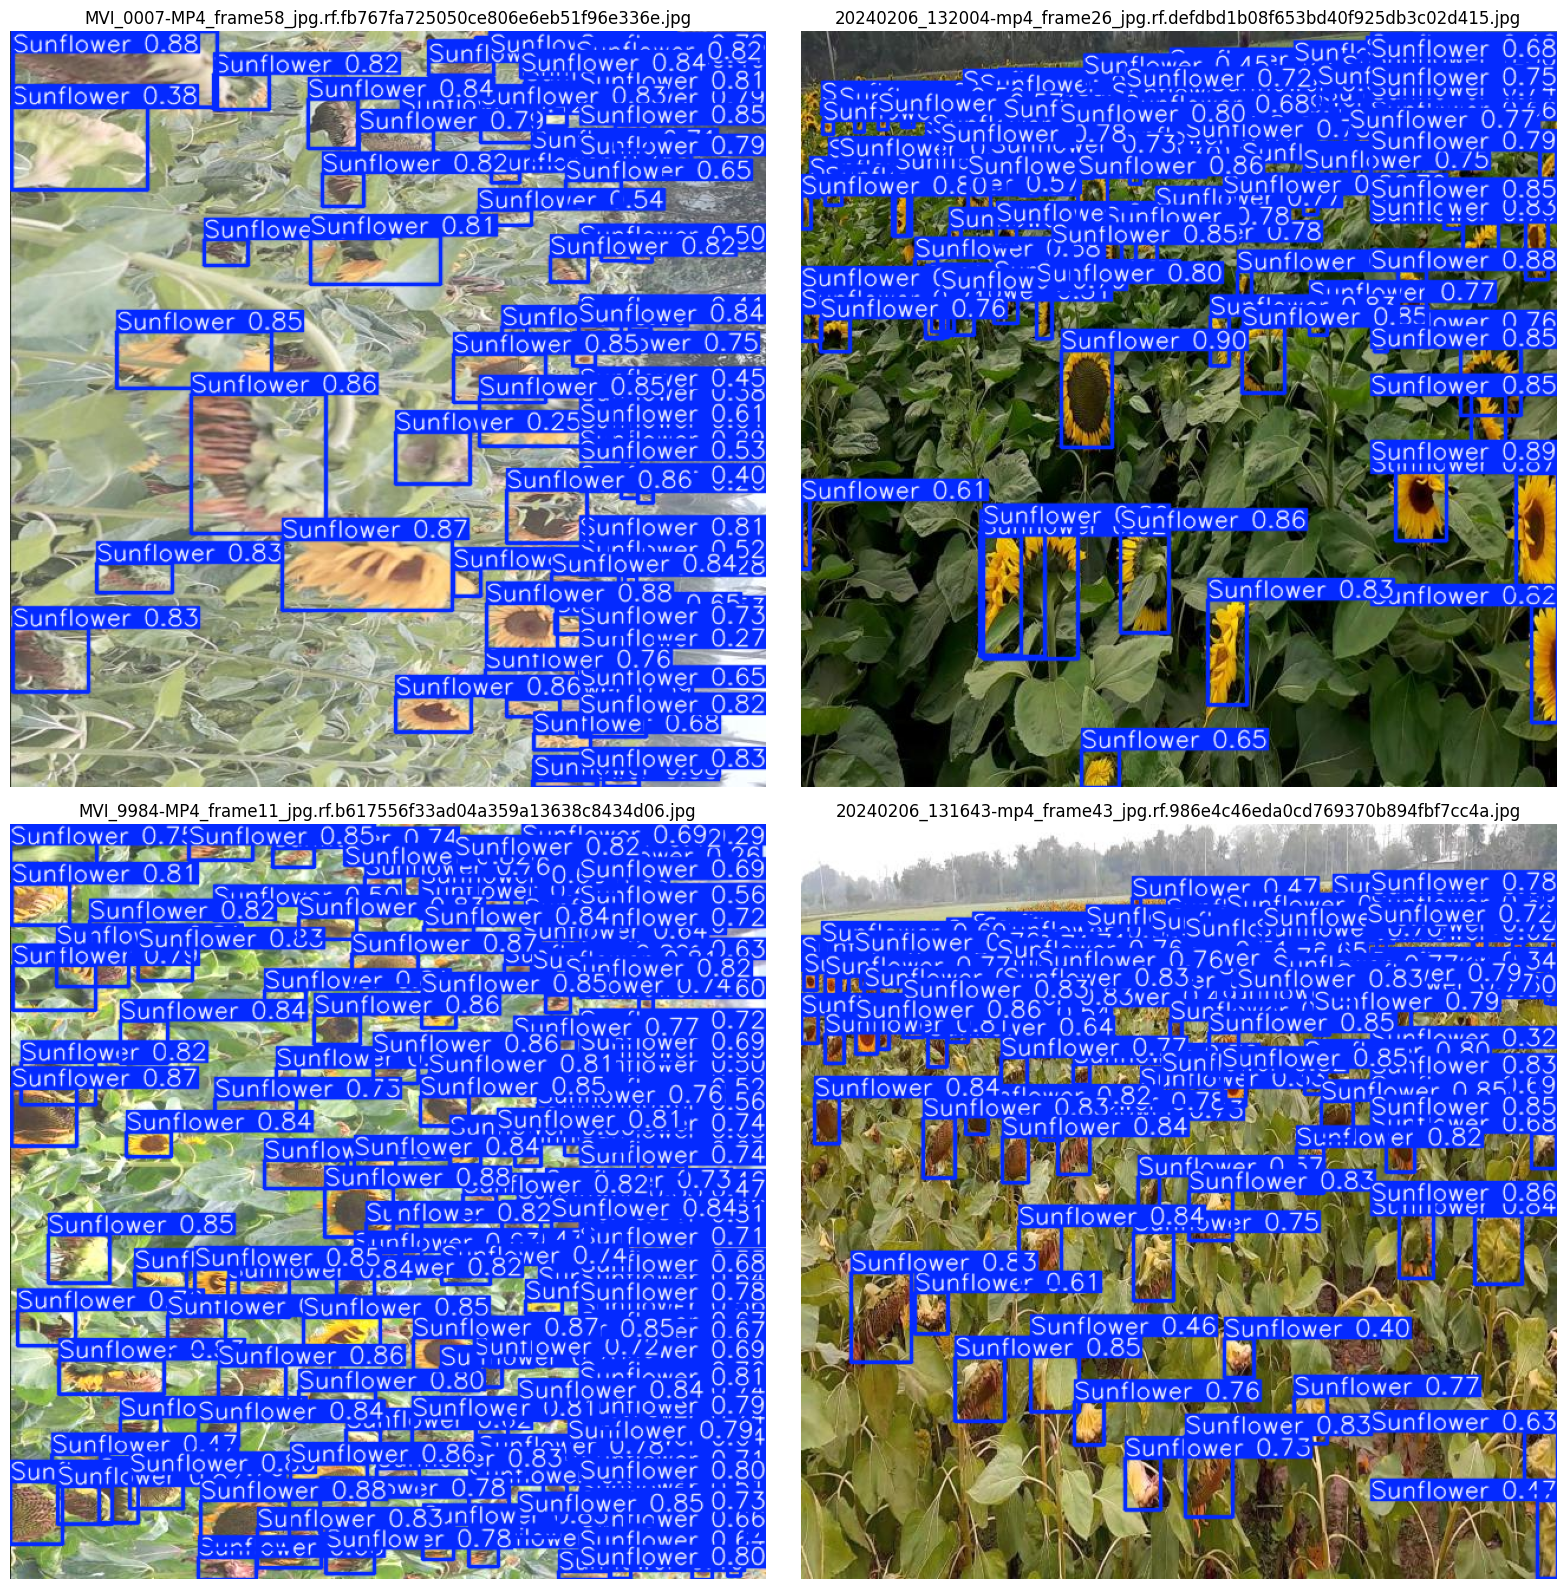

In [10]:
import random
import matplotlib.pyplot as plt
from pathlib import Path

# Ensure inline plotting for Jupyter
%matplotlib inline  

# Get all test images
test_imgs = list((WORK / "test/images").glob("*.*"))

if len(test_imgs) >= 4:
    # Pick 4 random images
    selected_imgs = random.sample(test_imgs, 4)

    plt.figure(figsize=(16, 16))
    for i, img_path in enumerate(selected_imgs, start=1):
        print(f"[{i}] Predicting: {img_path.name}")
        pred = model_det.predict(
            source=str(img_path),
            imgsz=640,
            conf=0.25,
            device=0 if device == "cuda" else "cpu",
            verbose=False
        )[0]

        plotted_img = pred.plot()[:, :, ::-1] if pred else plt.imread(img_path)

        plt.subplot(2, 2, i)
        plt.imshow(plotted_img)
        plt.axis("off")
        plt.title(img_path.name)

    plt.tight_layout()
    plt.show()
else:
    print(f"Not enough test images found (found {len(test_imgs)}, need at least 4).")
